In [1]:
from __future__ import print_function, absolute_import
import numpy as np
from scipy import signal, fft, io
from matplotlib import pyplot as plt

In [2]:
data = io.loadmat('../data/eth/ID1/Sz1.mat')

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'EEG'])

In [4]:
np.shape(data['EEG'])

(248320, 47)

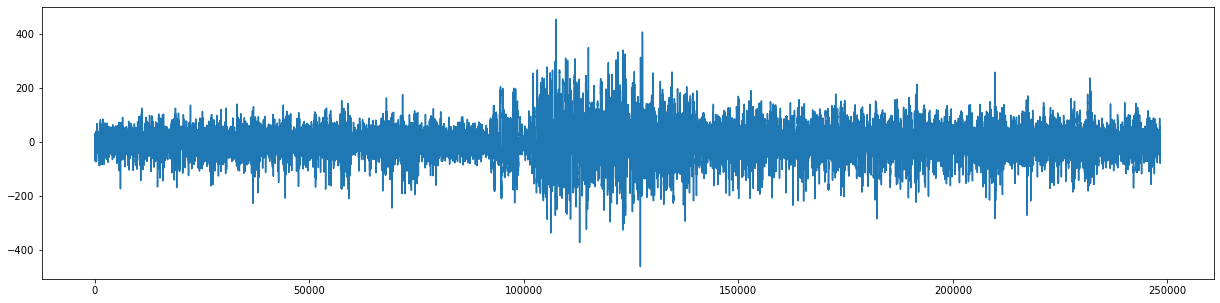

In [75]:
plt.figure(figsize=(21,5))
plt.plot(data['EEG'][:,15])

## STFT analysis begins here

In [373]:
nperseg=500*512//1000 # 500ms
f, t, ds = signal.stft(data['EEG'][:,0], fs=512, nperseg=nperseg, detrend='constant')

In [374]:
t = t[3:-3]
ds = np.abs(ds[:,3:-3])
idx = np.squeeze(np.where(f>=200))[0]
f = f[:idx]
ds = ds[:idx,:]
ds[0,:] = 0

<ipython-input-375-155d0c669c00>:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, np.log10(ds), shading='nearest'); plt.colorbar();


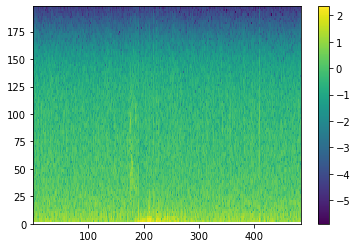

In [375]:
plt.pcolormesh(t, f, np.log10(ds), shading='nearest'); plt.colorbar();

In [376]:
from sklearn.preprocessing import normalize

In [458]:
dtft_norm = normalize(ds, norm='l2', copy=True, axis=0)

<ipython-input-459-2385d93c95c2>:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t,f,np.log10(dtft_norm), shading='nearest'); plt.colorbar();


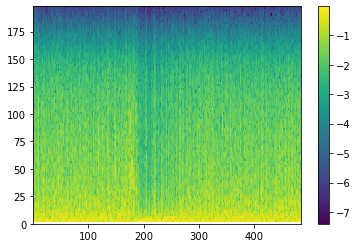

In [459]:
plt.pcolormesh(t,f,np.log10(dtft_norm), shading='nearest'); plt.colorbar();

In [460]:
mean_ds = np.mean(dtft_norm, axis=1)

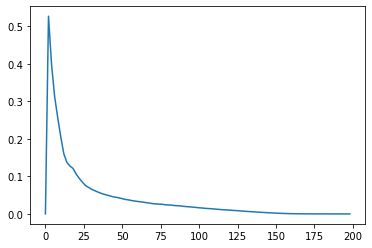

In [461]:
plt.plot(f, mean_ds)

In [462]:
ds_mc = ((dtft_norm.T - mean_ds).T).copy()

<ipython-input-463-42b6aa1973e5>:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t,f,np.log10(ds_mc), shading='nearest'); plt.colorbar();
<ipython-input-463-42b6aa1973e5>:1: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(t,f,np.log10(ds_mc), shading='nearest'); plt.colorbar();


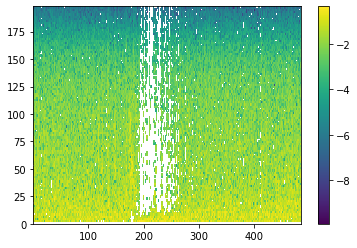

In [463]:
plt.pcolormesh(t,f,np.log10(ds_mc), shading='nearest'); plt.colorbar();

## SVD of DTFT

In [464]:
u1, s1, vh1 = np.linalg.svd(ds_mc, full_matrices=False)

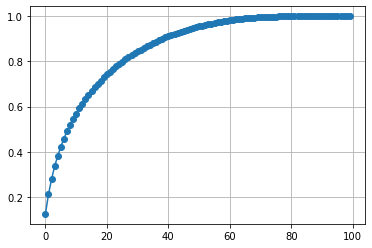

In [465]:
plt.plot(np.cumsum(s1)/np.sum(s1), 'o-'); plt.grid();

In [1728]:
ncomps = np.squeeze(np.where(np.cumsum(s1)/np.sum(s1) >= 0.50))[0]
print(ncomps)

8


In [467]:
ds_approx = u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ vh1[:ncomps,:]

<ipython-input-469-9097373d0a38>:2: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(t, f, np.log10((ds_approx.T + mean_ds.T).T), shading='nearest')


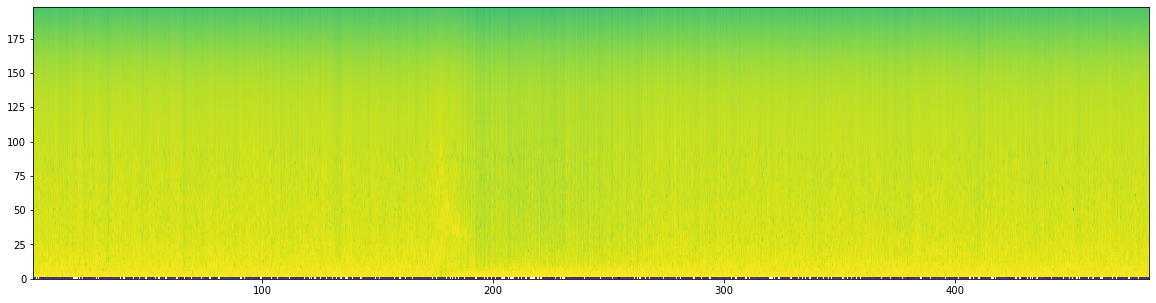

In [469]:
plt.figure(figsize=(20,5))
plt.pcolormesh(t, f, np.log10((ds_approx.T + mean_ds.T).T), shading='nearest')

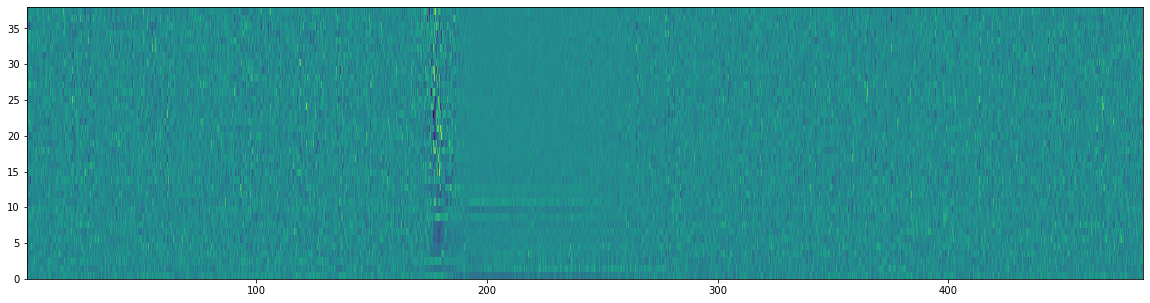

In [470]:
plt.figure(figsize=(20,5))
plt.pcolormesh(t, np.linspace(0, ncomps, ncomps), vh1[:ncomps,:])

## GMM fit to the data

In [471]:
from sklearn.mixture import BayesianGaussianMixture

In [968]:
nevents=50
bgm = BayesianGaussianMixture(n_components=nevents, max_iter=10000, covariance_type='diag')

In [1619]:
ncomps=10

In [1620]:
%time bgm.fit(vh1[:ncomps,:].T)

CPU times: user 18.1 s, sys: 1.16 s, total: 19.2 s
Wall time: 3.37 s


BayesianGaussianMixture(covariance_type='diag', max_iter=10000, n_components=50)

In [1621]:
bgm.converged_

True

In [1622]:
res = bgm.predict(vh1[:ncomps,:].T)

In [1623]:
means = (bgm.means_).T

In [1624]:
preds = u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ means
preds = (preds.T + mean_ds).T

In [1625]:
preds = normalize(preds, norm='l2', axis=0)

In [1626]:
ids, counts = np.unique(res, return_counts=True)
counts = counts/np.sum(counts)

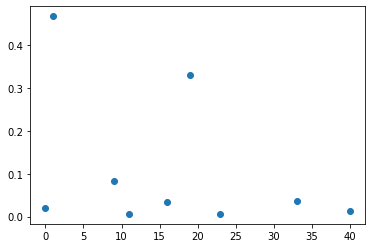

In [1627]:
plt.plot(ids, counts, 'o')

In [1628]:
print("Num evts: {}".format(len(np.unique(ids))))

Num evts: 9


In [1629]:
idx = np.argsort(counts)[::-1]

In [1630]:
dots = np.zeros((len(idx), len(idx)))
mean_norm = normalize(means, norm='l2', axis=0, copy=True)
for i in idx:
    for j in idx:
        dots[i,j] = np.dot(mean_norm[:,i], mean_norm[:,j])

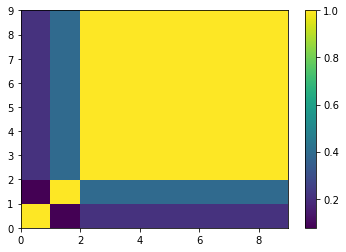

In [1631]:
plt.pcolormesh(np.abs(dots)); plt.colorbar()

## Filter the events based on the clustering of events

In [1632]:
from sklearn.cluster import SpectralClustering

In [1651]:
nsubclusters = 4
cluster2 = SpectralClustering(n_clusters=nsubclusters).fit(means.T)

In [1652]:
sub_labels=np.unique(cluster2.labels_)

In [1653]:
means2 = np.empty((ncomps,nsubclusters))
for subl, i in zip(sub_labels, range(len(sub_labels))):
    idxs = cluster2.labels_ == subl
    means2[:,i] = np.mean(means[:, idxs], axis=1)

In [1654]:
preds_mc = (u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ means2)
preds_mc = normalize(preds_mc, norm='l2', axis=0)

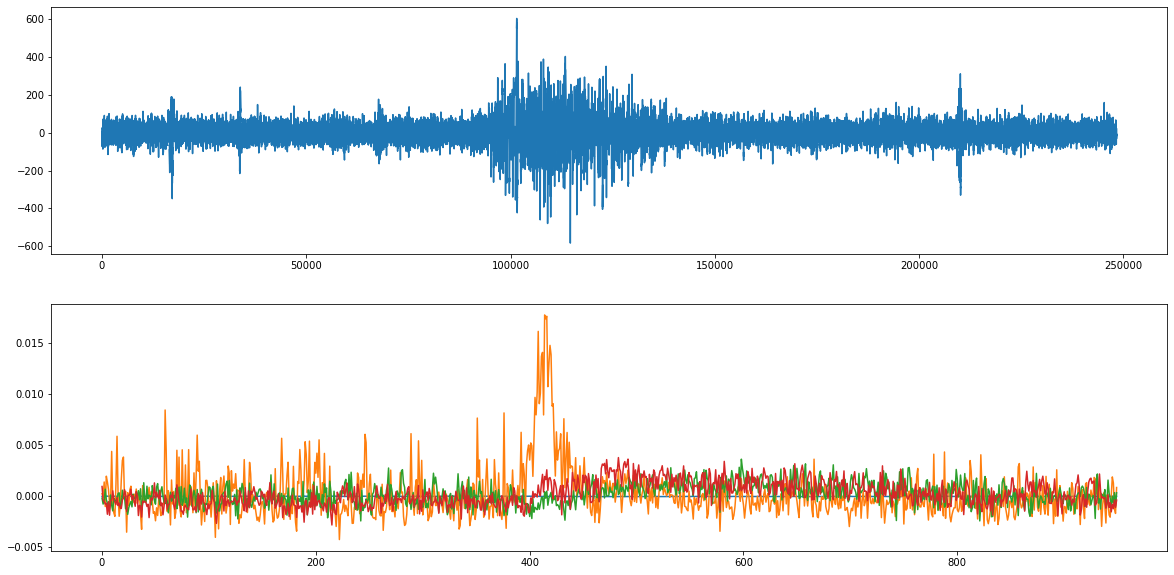

In [1655]:
plt.subplots(2,1,figsize=(20,10))
plt.subplot(2,1,1); plt.plot(data['EEG'][:,0]);
plt.subplot(2,1,2); plt.plot(np.dot(means2.T, vh1[:ncomps,300:1250]).T);

## Change labels of original array

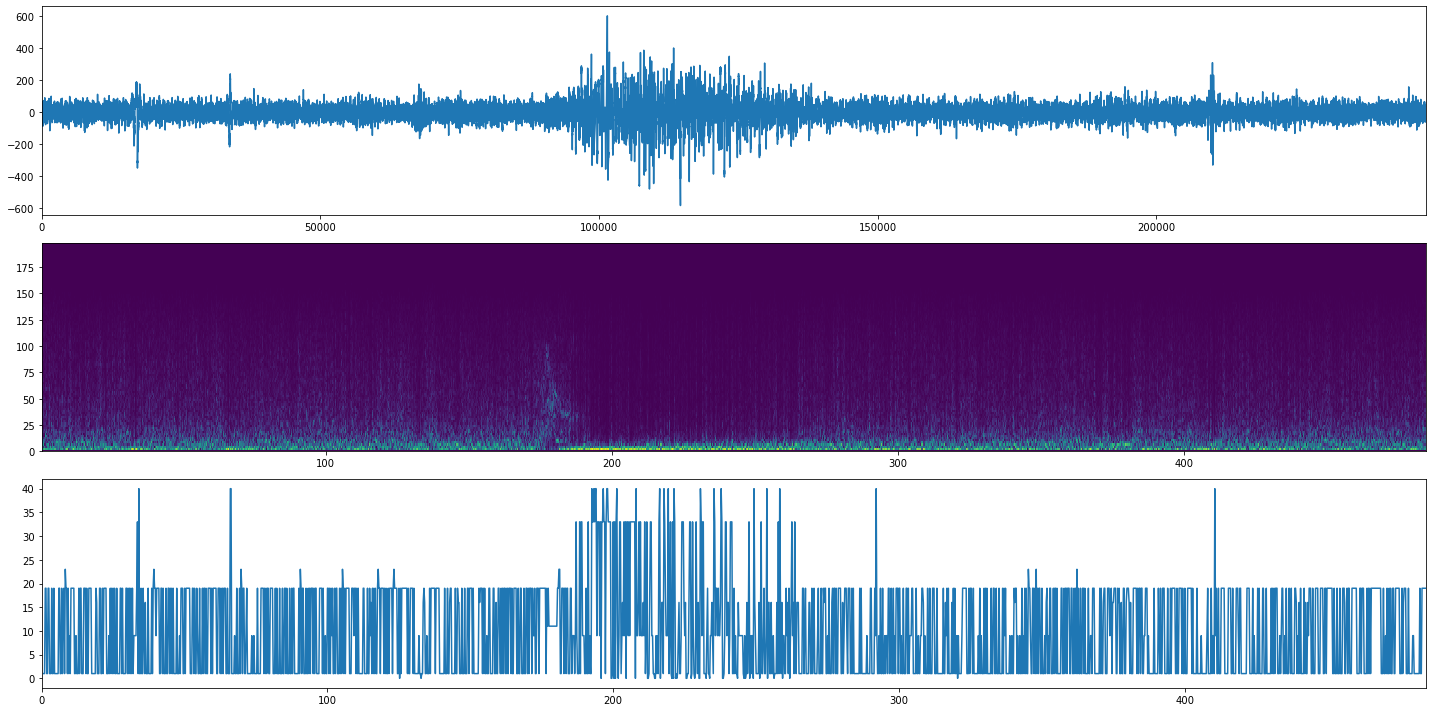

In [1656]:
plt.subplots(3,1, figsize=(20,10))
plt.subplot(3,1,1); plt.plot(data['EEG'][:,0]); plt.xlim([0, len(data['EEG'][:,0])])
plt.subplot(3,1,2); plt.pcolormesh(t, f, dtft_norm)
plt.subplot(3,1,3); plt.plot(t, res); plt.xlim([0, max(t)]); plt.tight_layout();

In [1657]:
# for every label in the original clustering, find the label in the cluster2 array and replace it

evs = np.zeros((len(res)))
for i in range(len(res)):
    this_label = res[i]
    new_label = cluster2.labels_[this_label]
    evs[i] = new_label
np.unique(evs)

array([0., 1., 2., 3.])

In [1658]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = evs.reshape(len(evs), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

([<matplotlib.axis.YTick at 0x7fcab88db040>,
 <a list of 4 Text major ticklabel objects>)

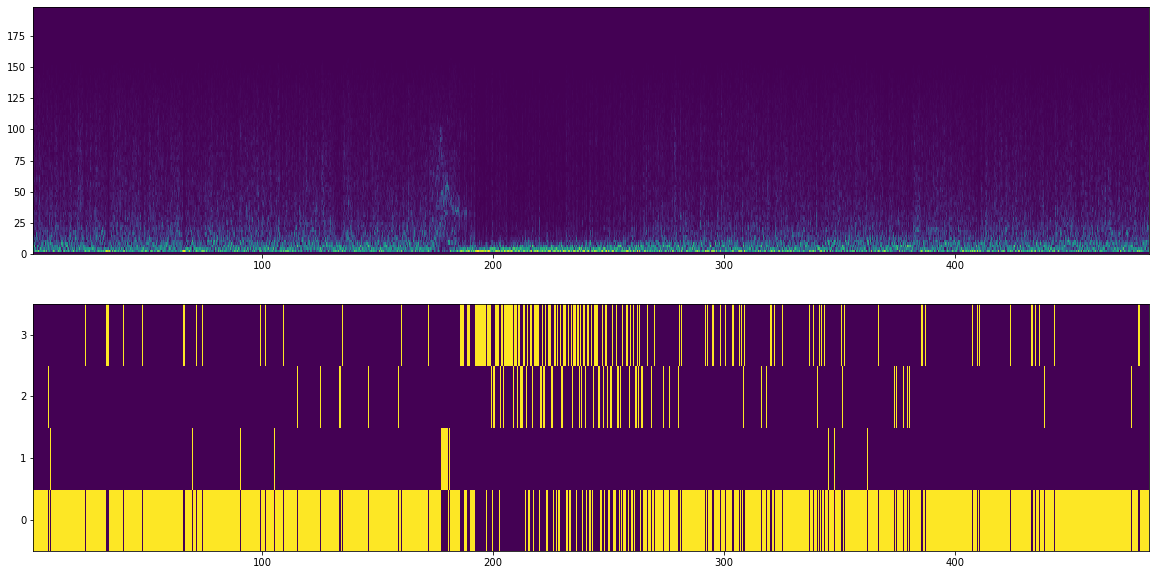

In [1662]:
plt.subplots(2,1, figsize=(20,10))
plt.subplot(2,1,1); plt.pcolormesh(t, f, dtft_norm)
plt.subplot(2,1,2); plt.pcolormesh(t, np.linspace(-0.5, 3.5, 5), onehot_encoded.T);  plt.yticks([0,1,2,3])

In [1663]:
evt_psd_mc = u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ means2

In [1664]:
evt_psd = normalize((evt_psd_mc.T + mean_ds).T, axis=0, norm="l2")

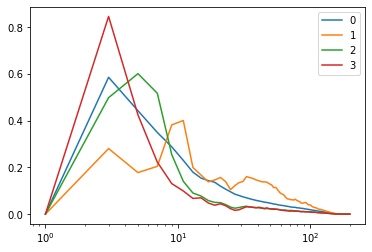

In [1665]:
for i in range(nsubclusters):
    plt.semilogx(f+1, evt_psd[:,i], label=i)
    plt.legend()

## Rough estimate of states

In [1678]:
window_size = 60 * (512 // nperseg) # window size in seconds
step_size = 2 * window_size//4 # window overlap

In [1679]:
evt_frequency = np.empty((len(np.arange(0, len(evs)-window_size, step_size)), nsubclusters))
start_points = np.arange(0, len(evs)-window_size, step_size)
t_states = np.array([])
for i in range(len(start_points)):
    evt_count = np.array([])
    t_states = np.append(t_states, t[start_points[i] + window_size//2])

    for j in range(nsubclusters):
        evt_count = np.append(evt_count, np.sum(evs[start_points[i]:start_points[i]+window_size]==j))
    
    evt_frequency[i,:]=evt_count/np.sum(evt_count)

In [1680]:
states_prior = 10
sgm = BayesianGaussianMixture(n_components=states_prior, covariance_type='diag').fit(evt_frequency)
states = sgm.predict(evt_frequency)

In [1681]:
nstates = len(np.unique(states))
print("nstates = {}".format(nstates))

nstates = 3


In [1682]:
onehot_encoder = OneHotEncoder(sparse=False)
states_encoded = states.reshape(len(states), 1)
onehot_states = onehot_encoder.fit_transform(states_encoded)

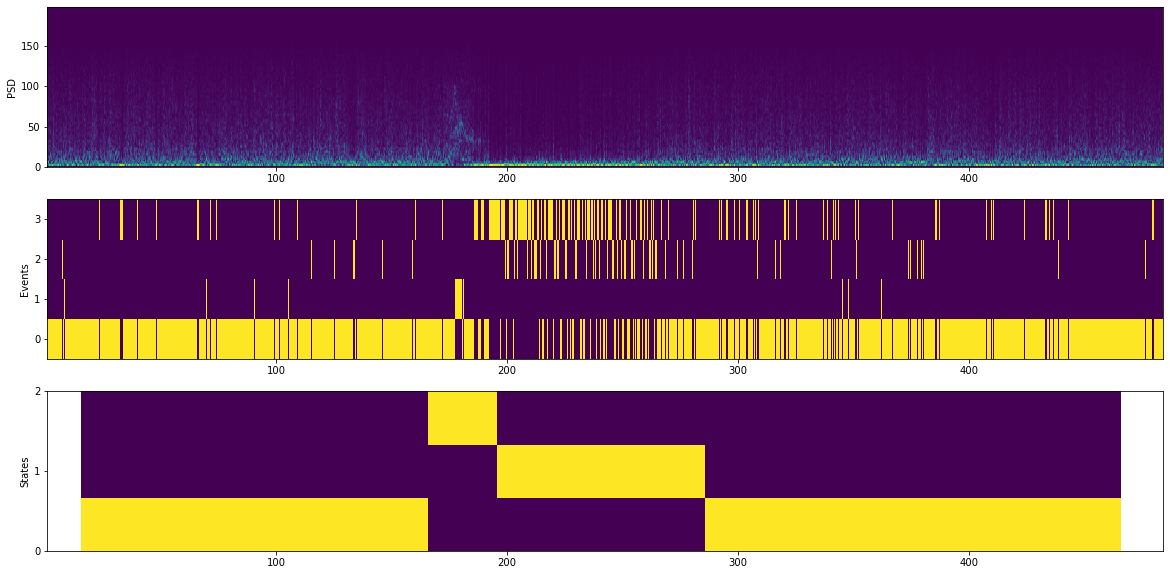

In [1683]:
plt.subplots(3,1, figsize=(20,10), sharex='all')
ax = plt.subplot(3,1,1); plt.pcolormesh(t, f, dtft_norm); plt.ylabel('PSD')
plt.subplot(3,1,2, sharex=ax); plt.pcolormesh(t, np.linspace(-0.5, 3.5, 5), onehot_encoded.T);  plt.yticks([0,1,2,3]); plt.ylabel('Events');
plt.subplot(3,1,3, sharex=ax); plt.pcolormesh(t_states, np.linspace(0, nstates-1, nstates+1), onehot_states.T);  plt.yticks(np.linspace(0,nstates-1,nstates)); plt.ylabel('States');